In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# load the data
file_url = 'https://archive.ics.uci.edu/static/public/222/data.csv'
df = pd.read_csv(file_url)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [5]:
# convert target var to numerical
df.y = df.y.map({'yes':1,'no':0})

# fill na
df.fillna('unknown', inplace=True)

# drop duration
df.drop('duration', axis=1, inplace=True)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# split the data into train/val/test with 60%/20%/20%
df_full, df_test = train_test_split(df, test_size=np.round(len(df)*.2).astype(int), random_state=42)
df_train, df_val = train_test_split(df_full, test_size=np.round(len(df)*.2).astype(int), random_state=42)

In [8]:
df_full = df_full.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['y'].values
y_val = df_val['y'].values
y_test = df_test['y'].values

del df_train['y']
del df_val['y']
del df_test['y']

In [9]:
cat = df_train.columns[df_train.dtypes=='object'].tolist()
num = df_train.columns[df_train.dtypes!='object'].tolist()

In [10]:
from sklearn.feature_extraction import DictVectorizer

In [11]:
# one-hot encode features
def one_hot_encode(df, features):
    df_dict=df[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(df_dict)
        
    return dv.transform(df_dict)

features = cat+num
X_train = one_hot_encode(df_train, features)
X_val = one_hot_encode(df_val, features)

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
# train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_proba_pred = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

In [15]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

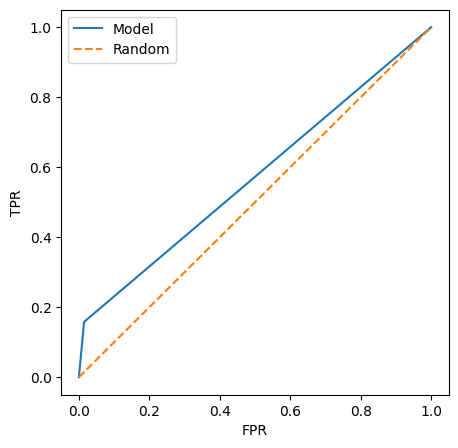

In [16]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [17]:
roc_auc_score(y_val, y_pred)

0.5716652366652366

In [18]:
from sklearn.model_selection import KFold

In [19]:
scores = []

# Iterate over the following C values: [0.01, 0.1, 0.5, 10]
for C in [0.01, 0.1, 0.5, 10]:
    auc_scores = []

    # Initialize KFold with the same parameters as previously
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # Iterate over different folds of df_full_train
    for train_idx, val_idx in kfold.split(df_full):
        # Split the data into train and validation
        df_train = df_full.iloc[train_idx]
        df_val = df_full.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        del df_train['y']
        del df_val['y']

        X_train = one_hot_encode(df_train, features)
        X_val = one_hot_encode(df_val, features)

        # train logistic regression model
        # Use these parametes for the model: 
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
    
        # Use AUC to evaluate the model on validation
        auc_scores.append(roc_auc_score(y_val, y_pred))

    #Compute the mean score as well as the std    
    scores.append((C, np.round(np.mean(auc_scores), 3), np.round(np.std(auc_scores), 3)))
    
df_c_scores = pd.DataFrame(scores, columns=['C', 'mean', 'std'])

In [20]:
df_c_scores

,C,mean,std
0,0.01,0.558,0.006
1,0.10,0.574,0.007
2,0.50,0.578,0.004
3,10.00,0.579,0.007


In [22]:
auc_score = [(0.58, 0.59)]

In [23]:
score = []

In [25]:
score.append((C, auc_score))

In [30]:
score += list(auc_score)

In [31]:
score

[(10, [(0.58, 0.59)]), (0.58, 0.59), (0.58, 0.59)]

In [32]:
score + score

[(10, [(0.58, 0.59)]),
 (0.58, 0.59),
 (0.58, 0.59),
 (10, [(0.58, 0.59)]),
 (0.58, 0.59),
 (0.58, 0.59)]

In [34]:
model.predict(y_train)

LogisticRegression(C=0.01, max_iter=1000, solver='liblinear')

In [35]:
scores = []

# Iterate over the following C values: [0.01, 0.1, 0.5, 10]
for C in [0.01, 0.1, 0.5, 10]:
    # auc_scores = []

    # Initialize KFold with the same parameters as previously
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    fold = 1
    
    # Iterate over different folds of df_full_train
    for train_idx, val_idx in kfold.split(df_full):
        # Split the data into train and validation
        df_train = df_full.iloc[train_idx]
        df_val = df_full.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        del df_train['y']
        del df_val['y']

        X_train = one_hot_encode(df_train, features)
        X_val = one_hot_encode(df_val, features)

        # train logistic regression model
        # Use these parametes for the model: 
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
    
        # Use AUC to evaluate the model on validation
        scores.append((
            C, 
            fold, 
            roc_auc_score(y_train, model.predict(X_train)), 
            roc_auc_score(y_val, y_pred)
            ))
        fold += 1

    #Compute the mean score as well as the std    
    # scores.append((C, np.round(np.mean(auc_scores), 3), np.round(np.std(auc_scores), 3)))
    
# df_c_scores = pd.DataFrame(scores, columns=['C', 'mean', 'std'])

ValueError: 3 columns passed, passed data had 4 columns

In [36]:
scores

[(0.01, 1, 0.5578784102911757, 0.5577540016405409),
 (0.01, 2, 0.5622570361014937, 0.5531219900253502),
 (0.01, 3, 0.5634726214049675, 0.5576188071539173),
 (0.01, 4, 0.559659842106021, 0.5684609499679176),
 (0.01, 5, 0.554351654278682, 0.551468243547419),
 (0.1, 1, 0.5768275163008432, 0.5790618438776969),
 (0.1, 2, 0.5784281834913764, 0.5664532231473329),
 (0.1, 3, 0.5762449208362955, 0.5681163593144466),
 (0.1, 4, 0.5744158986092305, 0.5840590510491466),
 (0.1, 5, 0.5718418425683394, 0.5741497223889556),
 (0.5, 1, 0.5810225336401298, 0.5824420731019017),
 (0.5, 2, 0.5847644812871349, 0.5734919473021763),
 (0.5, 3, 0.5839771257058192, 0.574187770725449),
 (0.5, 4, 0.5748075699262029, 0.5843445394867715),
 (0.5, 5, 0.5752554130233084, 0.5763696728691475),
 (10, 1, 0.5836200820497993, 0.587607331261335),
 (10, 2, 0.5815927884517222, 0.5700325077262172),
 (10, 3, 0.5848665150077118, 0.5740311045810028),
 (10, 4, 0.5797551005434909, 0.5880622458274192),
 (10, 5, 0.5742465621606665, 0.5755